In [54]:
import sys
import cv2
import os
import numpy as np

from keras.preprocessing.image import img_to_array
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("th")

# Import Tensorflow with multiprocessing
import tensorflow as tf
import multiprocessing as mp

print('deep learning modules imported')


deep learning modules imported


# Image Cropping

In [76]:
from random import randint

def cropImage(img, w, h, kind='ul'):
    #print(img.shape)
    
    # (C,h,w) => (h,w,C)
    img = np.rollaxis(img, 0, 3)
    
    W = img.shape[1]
    H = img.shape[0]
    
    if kind == 'ul':
        cropped = img[0:0+h, 0:0+w]
    elif kind == 'll':
        cropped = img[H-h:H, 0:0+w]
    elif kind == 'ur':
        cropped = img[0:0+h, W-w:W]
    elif kind == 'lr':
        cropped = img[H-h:H, W-w:W]
    elif kind == 'rand':
        x = randint(0, H-h)
        y = randint(0, W-w)
        cropped = img[x:x+h, y:y+w]
    else:
        raise ValueError("Invalid argument for 'kind': %s" + str(kind)) 
        
    # (h,w,C) => (C,h,w)
    cropped = np.rollaxis(cropped, 0, 3)
    cropped = np.rollaxis(cropped, 0, 3)
    
    return cropped

# Image Loading

In [91]:
IMG_PATH = '/Users/npaul/Documents/git/face-dl/data/orl'
del IMG_PATH 

def loadImage(path, output=sys.stdout, crop_size=None):
    image = cv2.imread(path)
    if image is None:
        print("Unable to load image '%s'" % path, file=output)
        return None
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    
    if crop_size is not None:
        image = cropImage(image, crop_size[0], crop_size[1], kind='ul')

    return image

In [56]:
import matplotlib.pyplot as plt

def previewImage(image, title=None):
    plt.figure()
    im = np.transpose(image, (1,2,0))
    #im = image
    rgb = np.fliplr(im.reshape(-1,3)).reshape(im.shape)
    plt.imshow(rgb)
    if title is not None:
        plt.title(title)
    plt.show()

In [57]:
def imagePaths(root):
    imgs = {}

    for dir in os.listdir(root):
        path = os.path.join(root, dir)
        if os.path.isdir(path):
            imgs[dir] = []
            for f in os.listdir(path):
                imgs[dir].append(os.path.join(path, f))
    return imgs

# Load and Organize Data

In [98]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

def loadAllImages(root, crop_size=None, do_shuffle=False, split=False, random_state=0, output=sys.stdout):
    """
    X, y = loadAllImages()
    X: image data
    y: labels
    """
    data = {}

    image_paths = imagePaths(root)

    labels = []
    imgs = []
    for k,paths in image_paths.items():
        for p in paths:
            labels.append(k)
            imgs.append(loadImage(p, crop_size=crop_size))

    X, y = np.array(imgs), labels        
    
    if do_shuffle:
        X, y = shuffle(X, y, random_state=random_state)
    
    class_names = sorted(list(set(labels))) 
    data['class_names'] = class_names
    data['num_classes'] = len(data['class_names'])
    # shape is (C,h,w) => (w,h)
    data['image_size']  = (X[0].shape[2], X[0].shape[1])

    # 'sXX' -> N
    y = [class_names.index(name) for name in y]
    
    y = np_utils.to_categorical(y, data['num_classes'])
        
    
    if split:
        # Split data
        # 75% Train
        # 12.5% Validation (Dev)
        # 12.5% Test

        # partition the data into training and testing splits using 75% of
        # the data for training and the remaining 25% for testing and validataion
        (X_train, X_test_val, y_train, y_test_val) = train_test_split(X,
            y, test_size=0.25, random_state=0)

        # Split test_val into testing and validation sets 50/50
        (X_test, X_val, y_test, y_val) = train_test_split(
            X_test_val, y_test_val, test_size=0.5, random_state=0)

        print('Training set size: %d' % len(y_train), file=output)
        print('Test set size: %d' % len(y_test), file=output)
        print('Validation set size: %d' % len(y_val), file=output)

        data['X_train'] = X_train
        data['X_test'] = X_test
        data['X_val'] = X_val
        data['y_train'] = y_train
        data['y_test'] = y_test
        data['y_val'] = y_val
    else:
        data['X'] = X
        data['y'] = y
        
    return data

In [81]:
import matplotlib.pyplot as plt
from random import randint

def preview_data(name, X_train, y_train, class_names, width=5, height=5, save=False, show=False):
    unique_imgs = 3
    offset = randint(0,len(y_train[0]) - (1 + unique_imgs)) 
    count = width * height
    fig = plt.figure(figsize=(width*1.7,height*2))
    
    def nextimg():
        label = offset + randint(0,unique_imgs-1)
        n = randint(0, len(y_train)-1)
        return label, n
    
    for i in range(count):
        label, n = nextimg()
        while int(np.argmax(y_train[n])) != label:
            label, n = nextimg()
            
        ax = fig.add_subplot(height,width,i+1, xticks=[], yticks=[])
        im = X_train[n,::]
        im = np.transpose(im, (1,2,0))
        rgb = np.fliplr(im.reshape(-1,3)).reshape(im.shape)
        plt.imshow(rgb)
        ax.set_title('%s : %d' % (class_names[int(np.argmax(y_train[n]))], n))
    
    plt.suptitle(name)
    if save:
        plt.savefig('plots/preview_%s.png' % name)
    if show:
        plt.show()
        
print('preview_data')

preview_data


Training set size: 3363
Test set size: 561
Validation set size: 561


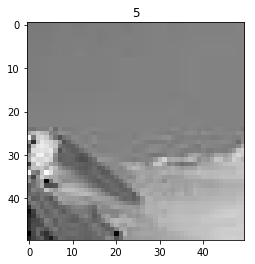

In [105]:
from time import time

data = loadAllImages('/Users/npaul/Documents/git/face-dl/data/fifteen_scenes', crop_size=(50,50), do_shuffle=True, random_state=int(time()), split=True)
X = data['X_train']
y = data['y_train']
previewImage(test_image, title=np.argmax(y[2]))

num_classes: 15
image_size: (50, 50)
class_names: ['CALsuburb', 'MITcoast', 'MITforest', 'MIThighway', 'MITinsidecity', 'MITmountain', 'MITopencountry', 'MITstreet', 'MITtallbuilding', 'PARoffice', 'bedroom', 'industrial', 'kitchen', 'livingroom', 'store']


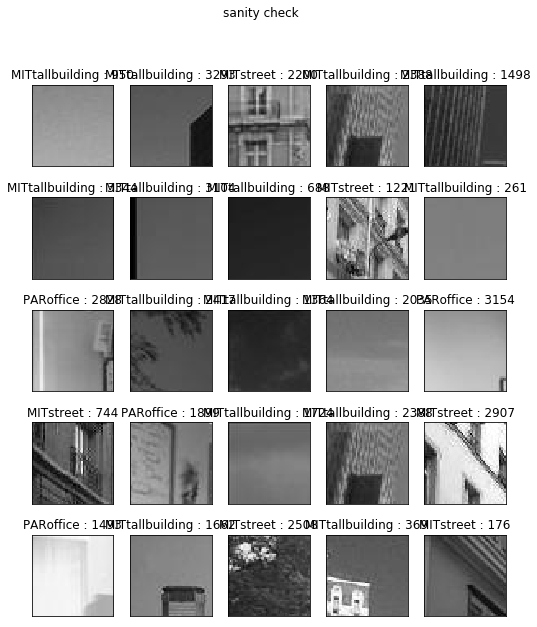

In [106]:
for k in ['num_classes', 'image_size', 'class_names']:
    print('%s: %s' % (k, data[k]))
    
preview_data('sanity check', data['X_train'], data['y_train'], data['class_names'], show=True)

# The Network

In [15]:
# Define the LeNet Model
class LeNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model
        model = Sequential()
        inputShape = (height, width, depth)
 
        # if we are using "channels first", update the input shape
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
        
        # first set of CONV => RELU => POOL layers
        model.add(Conv2D(20, (5, 5), padding="same",
            input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        # second set of CONV => RELU => POOL layers
        model.add(Conv2D(50, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation("relu"))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model
    
print('LeNet model defined')

LeNet model defined


In [38]:
def train_model(name, trainX, trainY, valX, valY, num_classes, img_size, epochs, batch_size=45, init_lr=1e-3, output=sys.stdout):
    aug = ImageDataGenerator(rotation_range=30, 
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode="nearest")
    
    # initialize the model
    print("[INFO] building model '%s' ..." % name, file=output)
    model = LeNet.build(width=img_size[0],
                        height=img_size[1],
                        depth=3,
                        classes=num_classes)
    
    print(model.summary())
    
    loss = 'binary_crossentropy' if num_classes == 2 else 'categorical_crossentropy'
    
    print("[INFO] compiling model '%s' ..." % name, file=output)
    opt = Adam(lr=init_lr, decay=init_lr / epochs)
    #opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss=loss,
                  optimizer=opt,
                  metrics=["accuracy"])
    
    trainY_idx = np.arange(len(trainY[0]))

    # train the network
    steps_per_epoch = len(trainX) // batch_size
    print('Steps per epoch:', steps_per_epoch)
    print("[INFO] training network...", file=output)
    H = model.fit_generator(aug.flow(trainX, trainY),
                            validation_data=(valX, valY),
                            steps_per_epoch=steps_per_epoch,
                            epochs=epochs, verbose=1)

    # save the model to disk
    print("[INFO] serializing network...", file=output)
    save_path = 'models/%s.model' % name
    print("Saving model as ./%s" % save_path, file=output)
    model.save(save_path)
    
    return H, model

print('train_model_weighted')

train_model_weighted


epochs = 2
history, model = train_model('sample',
                data['X_train'],
                data['y_train'],
                data['X_val'],
                data['y_val'],
                data['num_classes'],
                data['image_size'],
                epochs) #epochs

# Evaluation

In [17]:
# plot the training loss and accuracy
def plot_training_history(name, H, epochs, save=False, show=False):
    plt.figure()
    N = epochs
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
    plt.title("Training Loss and Accuracy on classes")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    
    if save:
        plt.savefig('plots/validation_history_%s.png' % name)
    if show:
        plt.show()

print('plot_history()')

plot_history()


In [18]:
#plot_training_history('test', history, epochs, show=True)

In [19]:
def run_test(data, model, f=sys.stdout):
    score = model.evaluate(data['X_test'], data['y_test'])
    print('Loss on test data: %s' % score[0], file=f)
    print('Accuracy on test data: %s' % score[1], file=f)

    y_pred = model.predict(data['X_test'])

    # prediction data
    num_correct = np.sum(np.argmax(data['y_test'], axis=1) == np.argmax(y_pred, axis=1))
    #print(data['y_test'])
    #print(y_pred)
    print('Correct / Total: %d/%d' % (num_correct, len(data['y_test'])), file=f)
    
    data['y_pred'] = y_pred

In [20]:
#run_test(data, model)

In [21]:
def preview_predicted_data(name, X_test, y_truth, y_pred, class_names, width=5, height=5, save=False, show=False):
    count = width * height
    if len(X_test) < count:
        count = X_test
        height = 2
        width = count // 2
        
    fig = plt.figure(figsize=(width*1.7,height*2))
    for i in range(count):
        n = randint(0,len(y_truth)-1)
        ax = fig.add_subplot(height,width,i+1, xticks=[], yticks=[])
        im = X_test[n,::]
        im = np.transpose(im, (1,2,0))
        rgb = np.fliplr(im.reshape(-1,3)).reshape(im.shape)
        plt.imshow(rgb)
        #if y_truth[n] == y_pred[n]:
        #    title = class_names[int(np.argmax(y_truth[n]))]
        #else:
        title = '%s/%s' % (class_names[int(np.argmax(y_pred[n]))], class_names[int(np.argmax(y_truth[n]))])
        ax.set_title(title)
    
    plt.suptitle('%s: predicted / correct' % name)
    if save:
        plt.savefig('plots/preview_%s.png' % name)
    if show:
        plt.show()
        
print('preview_data')

preview_data


In [22]:
#preview_predicted_data('test', data['X_test'], data['y_test'], data['y_pred'], data['class_names'], show=True)

In [23]:
def quickTest(name, data, epochs):
    history, model = train_model(name,
                    data['X_train'],
                    data['y_train'],
                    data['X_val'],
                    data['y_val'],
                    data['num_classes'],
                    data['image_size'],
                    epochs) #epochs
    
    plot_training_history(name, history, epochs, show=True)
    
    # creates data['y_pred']
    run_test(data, model)
    
    preview_predicted_data('test', 
                           data['X_test'], 
                           data['y_test'], 
                           data['y_pred'], 
                           data['class_names'], 
                           show=True)
    

In [24]:
#quickTest('test', data, 2)

In [25]:
#quickTest('test', data, 40)

In [26]:
def cropData(data, w, h, kind='ur'):
    data_cropped = dict(data)
    
    for k in ['X_train', 'X_val', 'X_test']:
        cropped = []
        for i in range(len(data[k])):
            cropped.append(cropImage(data[k][i], w, h, kind))

        data_cropped[k] = np.array(cropped)
    
    data_cropped['image_size'] = (w,h)
    
    return data_cropped

[INFO] building model 'crop_60x60_ur' ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 60, 60)        1520      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 60, 60)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 30, 30)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 30, 30)        25050     
_________________________________________________________________
activation_2 (Activation)    (None, 50, 30, 30)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 15, 15)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None

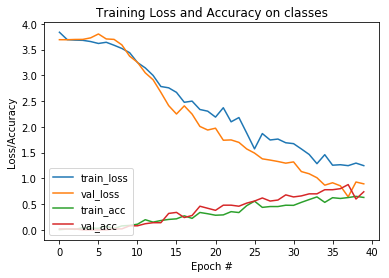

50/50 [==============================] - 1s 15ms/step
Loss on test data: 0.8803854012489318
Accuracy on test data: 0.7000000047683715
Correct / Total: 35/50


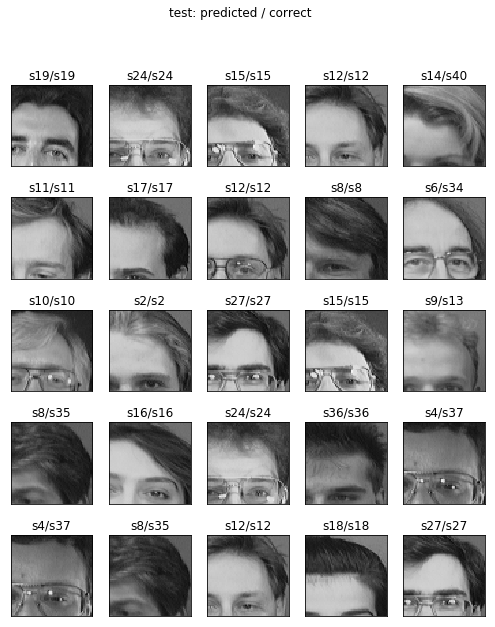

In [27]:
quickTest('crop_60x60_ur', cropData(data, 60, 60, kind='ur'), 40)

[INFO] building model 'crop_30x30_ur' ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 20, 30, 30)        1520      
_________________________________________________________________
activation_5 (Activation)    (None, 20, 30, 30)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 20, 15, 15)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 15, 15)        25050     
_________________________________________________________________
activation_6 (Activation)    (None, 50, 15, 15)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 7, 7)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None

Epoch 49/70
6/6 [==============================] - 1s 202ms/step - loss: 1.0065 - acc: 0.6494 - val_loss: 1.1632 - val_acc: 0.6000
Epoch 50/70
6/6 [==============================] - 1s 209ms/step - loss: 1.0504 - acc: 0.6615 - val_loss: 1.2233 - val_acc: 0.6000
Epoch 51/70
6/6 [==============================] - 1s 189ms/step - loss: 0.9679 - acc: 0.6663 - val_loss: 1.1148 - val_acc: 0.6000
Epoch 52/70
6/6 [==============================] - 1s 212ms/step - loss: 1.1748 - acc: 0.6458 - val_loss: 1.1413 - val_acc: 0.6600
Epoch 53/70
6/6 [==============================] - 1s 191ms/step - loss: 1.1158 - acc: 0.6663 - val_loss: 1.0517 - val_acc: 0.6600
Epoch 54/70
6/6 [==============================] - 2s 250ms/step - loss: 0.8071 - acc: 0.7552 - val_loss: 1.2305 - val_acc: 0.6200
Epoch 55/70
6/6 [==============================] - 1s 237ms/step - loss: 0.8770 - acc: 0.7331 - val_loss: 1.1113 - val_acc: 0.6000
Epoch 56/70
6/6 [==============================] - 1s 196ms/step - loss: 0.7778 - a

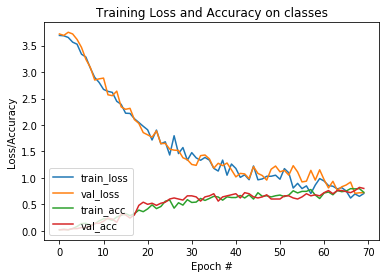

50/50 [==============================] - 0s 3ms/step
Loss on test data: 0.6761191987991333
Accuracy on test data: 0.7800000047683716
Correct / Total: 39/50


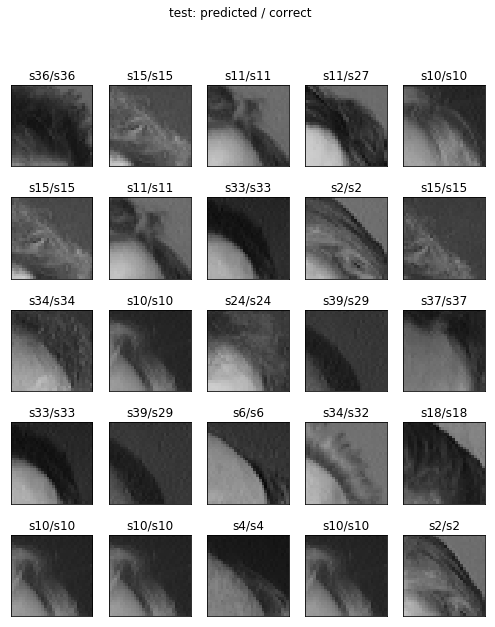

In [28]:
quickTest('crop_30x30_ur', cropData(data, 30, 30, kind='ur'), 70)

[INFO] building model 'crop_10x10_ur' ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 20, 10, 10)        1520      
_________________________________________________________________
activation_9 (Activation)    (None, 20, 10, 10)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 20, 5, 5)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 50, 5, 5)          25050     
_________________________________________________________________
activation_10 (Activation)   (None, 50, 5, 5)          0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 50, 2, 2)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None

6/6 [==============================] - 0s 27ms/step - loss: 1.7282 - acc: 0.3739 - val_loss: 2.3854 - val_acc: 0.3400
Epoch 111/120
6/6 [==============================] - 0s 31ms/step - loss: 1.7891 - acc: 0.3845 - val_loss: 2.5637 - val_acc: 0.2000
Epoch 112/120
6/6 [==============================] - 0s 33ms/step - loss: 1.8840 - acc: 0.2865 - val_loss: 2.3181 - val_acc: 0.3600
Epoch 113/120
6/6 [==============================] - 0s 32ms/step - loss: 1.7881 - acc: 0.3698 - val_loss: 2.3502 - val_acc: 0.3800
Epoch 114/120
6/6 [==============================] - 0s 43ms/step - loss: 1.8086 - acc: 0.3629 - val_loss: 2.4652 - val_acc: 0.2600
Epoch 115/120
6/6 [==============================] - 0s 28ms/step - loss: 1.8341 - acc: 0.3125 - val_loss: 2.4250 - val_acc: 0.3200
Epoch 116/120
6/6 [==============================] - 0s 34ms/step - loss: 1.7844 - acc: 0.3438 - val_loss: 2.4326 - val_acc: 0.2600
Epoch 117/120
6/6 [==============================] - 0s 29ms/step - loss: 1.8007 - acc: 0.

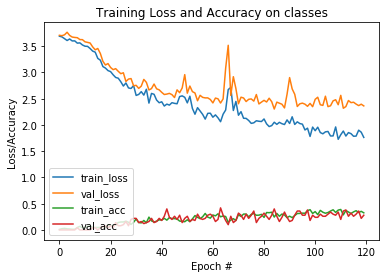

50/50 [==============================] - 0s 562us/step
Loss on test data: 2.1776516532897947
Accuracy on test data: 0.32000000059604644
Correct / Total: 16/50


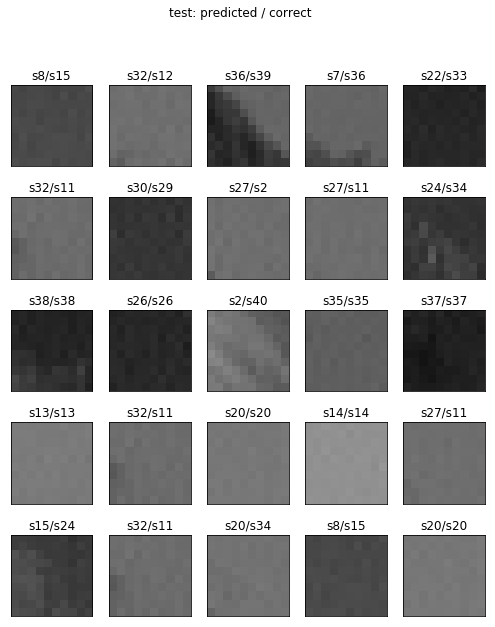

In [29]:
quickTest('crop_10x10_ur', cropData(data, 10, 10, kind='ur'), 120)

[INFO] building model 'crop_10x10_ul' ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 20, 10, 10)        1520      
_________________________________________________________________
activation_13 (Activation)   (None, 20, 10, 10)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 20, 5, 5)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 50, 5, 5)          25050     
_________________________________________________________________
activation_14 (Activation)   (None, 50, 5, 5)          0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 50, 2, 2)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None

6/6 [==============================] - 0s 25ms/step - loss: 1.9348 - acc: 0.3029 - val_loss: 2.3435 - val_acc: 0.3000
Epoch 111/120
6/6 [==============================] - 0s 33ms/step - loss: 1.8985 - acc: 0.3438 - val_loss: 2.4751 - val_acc: 0.2800
Epoch 112/120
6/6 [==============================] - ETA: 0s - loss: 2.0133 - acc: 0.306 - 0s 35ms/step - loss: 2.0197 - acc: 0.3188 - val_loss: 2.2113 - val_acc: 0.3400
Epoch 113/120
6/6 [==============================] - 0s 25ms/step - loss: 1.9636 - acc: 0.3464 - val_loss: 2.5440 - val_acc: 0.2600
Epoch 114/120
6/6 [==============================] - 0s 31ms/step - loss: 2.2310 - acc: 0.2656 - val_loss: 2.6994 - val_acc: 0.1800
Epoch 115/120
6/6 [==============================] - 0s 23ms/step - loss: 2.0813 - acc: 0.3200 - val_loss: 2.4807 - val_acc: 0.2200
Epoch 116/120
6/6 [==============================] - 0s 34ms/step - loss: 1.9843 - acc: 0.2882 - val_loss: 2.4691 - val_acc: 0.1800
Epoch 117/120
6/6 [==============================] -

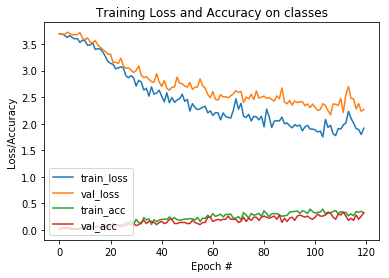

50/50 [==============================] - 0s 1ms/step
Loss on test data: 2.0545911312103273
Accuracy on test data: 0.3200000047683716
Correct / Total: 16/50


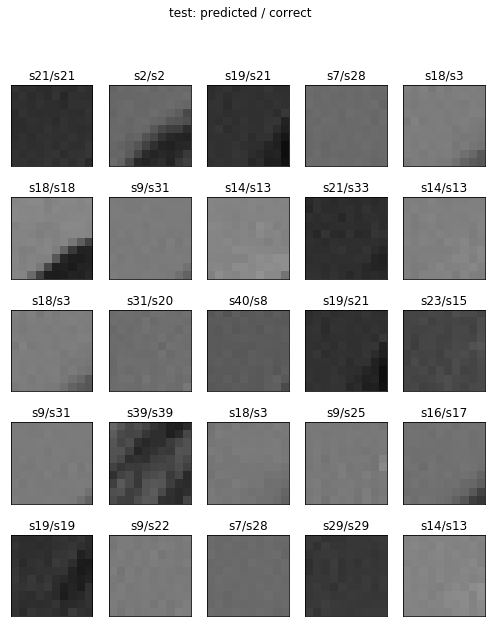

[INFO] building model 'crop_10x10_ll' ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 20, 10, 10)        1520      
_________________________________________________________________
activation_17 (Activation)   (None, 20, 10, 10)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 20, 5, 5)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 50, 5, 5)          25050     
_________________________________________________________________
activation_18 (Activation)   (None, 50, 5, 5)          0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 50, 2, 2)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None

Epoch 49/120
6/6 [==============================] - 0s 34ms/step - loss: 2.1117 - acc: 0.3073 - val_loss: 1.9757 - val_acc: 0.3600
Epoch 50/120
6/6 [==============================] - 0s 26ms/step - loss: 2.0693 - acc: 0.2351 - val_loss: 1.9389 - val_acc: 0.3600
Epoch 51/120
6/6 [==============================] - 0s 34ms/step - loss: 1.8027 - acc: 0.3962 - val_loss: 1.9479 - val_acc: 0.3800
Epoch 52/120
6/6 [==============================] - 0s 32ms/step - loss: 1.8847 - acc: 0.4115 - val_loss: 1.8030 - val_acc: 0.4600
Epoch 53/120
6/6 [==============================] - 0s 38ms/step - loss: 1.9136 - acc: 0.3930 - val_loss: 1.8346 - val_acc: 0.3800
Epoch 54/120
6/6 [==============================] - 0s 41ms/step - loss: 1.7730 - acc: 0.4010 - val_loss: 1.9101 - val_acc: 0.2800
Epoch 55/120
6/6 [==============================] - 0s 26ms/step - loss: 1.7333 - acc: 0.4460 - val_loss: 1.8542 - val_acc: 0.4400
Epoch 56/120
6/6 [==============================] - 0s 34ms/step - loss: 1.7734 - a

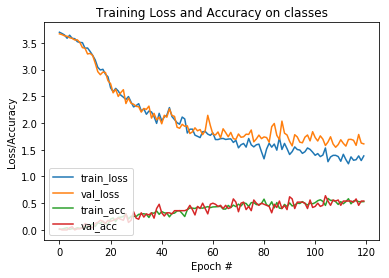

50/50 [==============================] - 0s 462us/step
Loss on test data: 1.5678549575805665
Accuracy on test data: 0.4400000095367432
Correct / Total: 22/50


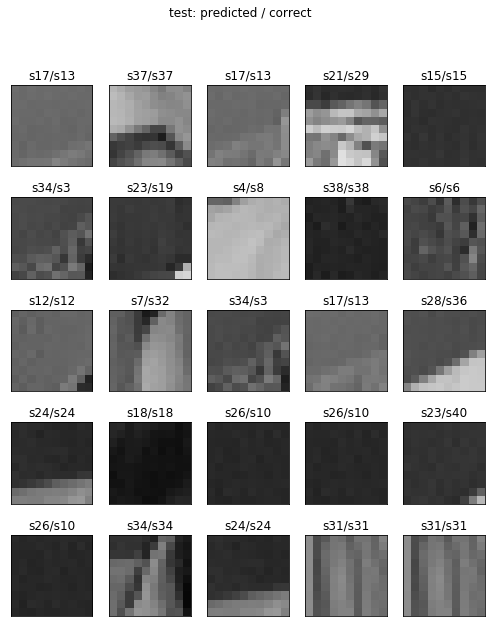

[INFO] building model 'crop_10x10_ur' ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 20, 10, 10)        1520      
_________________________________________________________________
activation_21 (Activation)   (None, 20, 10, 10)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 20, 5, 5)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 50, 5, 5)          25050     
_________________________________________________________________
activation_22 (Activation)   (None, 50, 5, 5)          0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 50, 2, 2)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None

Epoch 49/120
6/6 [==============================] - 0s 44ms/step - loss: 2.4515 - acc: 0.2396 - val_loss: 2.4269 - val_acc: 0.1400
Epoch 50/120
6/6 [==============================] - 0s 31ms/step - loss: 2.4361 - acc: 0.2373 - val_loss: 2.5406 - val_acc: 0.1600
Epoch 51/120
6/6 [==============================] - 0s 43ms/step - loss: 2.3669 - acc: 0.2670 - val_loss: 2.3945 - val_acc: 0.2200
Epoch 52/120
6/6 [==============================] - 0s 53ms/step - loss: 2.4018 - acc: 0.2448 - val_loss: 2.3215 - val_acc: 0.1800
Epoch 53/120
6/6 [==============================] - 0s 29ms/step - loss: 2.2204 - acc: 0.2924 - val_loss: 2.4069 - val_acc: 0.1800
Epoch 54/120
6/6 [==============================] - 0s 41ms/step - loss: 2.2532 - acc: 0.2448 - val_loss: 2.2760 - val_acc: 0.3200
Epoch 55/120
6/6 [==============================] - 0s 26ms/step - loss: 2.3446 - acc: 0.3135 - val_loss: 2.2787 - val_acc: 0.2200
Epoch 56/120
6/6 [==============================] - 0s 31ms/step - loss: 2.2432 - a

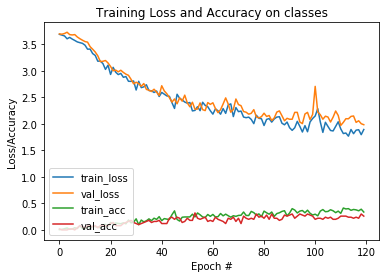

50/50 [==============================] - 0s 563us/step
Loss on test data: 1.8250288486480712
Accuracy on test data: 0.3600000011920929
Correct / Total: 18/50


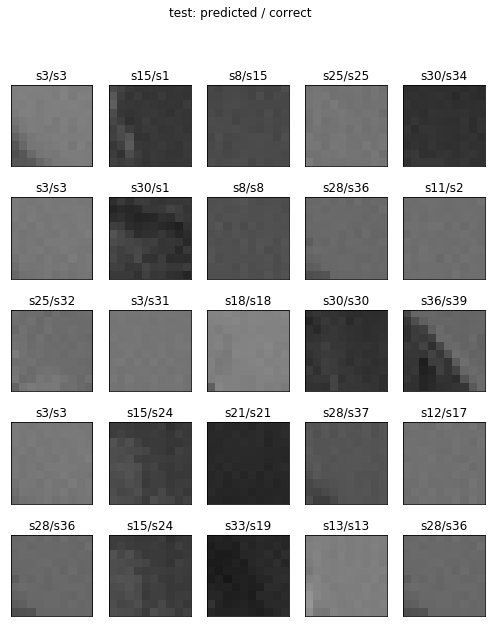

[INFO] building model 'crop_10x10_lr' ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 20, 10, 10)        1520      
_________________________________________________________________
activation_25 (Activation)   (None, 20, 10, 10)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 20, 5, 5)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 50, 5, 5)          25050     
_________________________________________________________________
activation_26 (Activation)   (None, 50, 5, 5)          0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 50, 2, 2)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None

Epoch 49/120
6/6 [==============================] - 0s 32ms/step - loss: 1.9826 - acc: 0.3708 - val_loss: 2.3431 - val_acc: 0.2600
Epoch 50/120
6/6 [==============================] - 0s 24ms/step - loss: 2.1745 - acc: 0.2447 - val_loss: 2.3940 - val_acc: 0.2400
Epoch 51/120
6/6 [==============================] - 0s 34ms/step - loss: 2.0264 - acc: 0.3333 - val_loss: 2.3307 - val_acc: 0.1800
Epoch 52/120
6/6 [==============================] - 0s 38ms/step - loss: 2.0254 - acc: 0.2924 - val_loss: 2.1637 - val_acc: 0.3400
Epoch 53/120
6/6 [==============================] - 0s 25ms/step - loss: 1.9933 - acc: 0.3412 - val_loss: 2.4551 - val_acc: 0.2200
Epoch 54/120
6/6 [==============================] - 0s 36ms/step - loss: 1.9775 - acc: 0.3594 - val_loss: 2.2963 - val_acc: 0.2800
Epoch 55/120
6/6 [==============================] - 0s 23ms/step - loss: 1.9841 - acc: 0.3125 - val_loss: 2.1677 - val_acc: 0.3200
Epoch 56/120
6/6 [==============================] - 0s 34ms/step - loss: 1.9594 - a

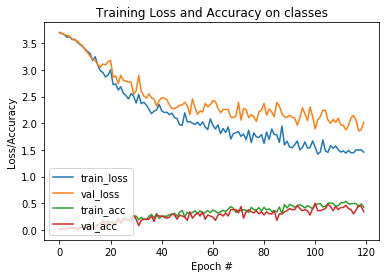

50/50 [==============================] - 0s 481us/step
Loss on test data: 2.031864252090454
Accuracy on test data: 0.3800000047683716
Correct / Total: 19/50


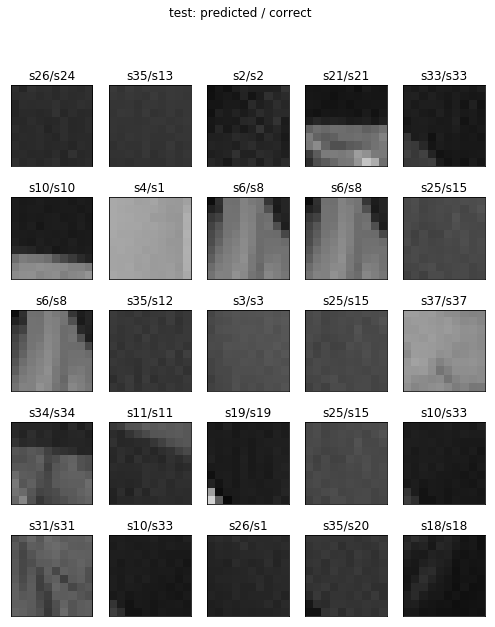

[INFO] building model 'crop_10x10_rand' ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 20, 10, 10)        1520      
_________________________________________________________________
activation_29 (Activation)   (None, 20, 10, 10)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 20, 5, 5)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 50, 5, 5)          25050     
_________________________________________________________________
activation_30 (Activation)   (None, 50, 5, 5)          0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 50, 2, 2)          0         
_________________________________________________________________
flatten_8 (Flatten)          (No

Epoch 49/120
6/6 [==============================] - 0s 36ms/step - loss: 3.4059 - acc: 0.0521 - val_loss: 3.9829 - val_acc: 0.0400
Epoch 50/120
6/6 [==============================] - 0s 22ms/step - loss: 3.3956 - acc: 0.0996 - val_loss: 3.9609 - val_acc: 0.0400
Epoch 51/120
6/6 [==============================] - 0s 36ms/step - loss: 3.3834 - acc: 0.0938 - val_loss: 4.0612 - val_acc: 0.0600
Epoch 52/120
6/6 [==============================] - 0s 35ms/step - loss: 3.4224 - acc: 0.0847 - val_loss: 3.9382 - val_acc: 0.0400
Epoch 53/120
6/6 [==============================] - 0s 25ms/step - loss: 3.3265 - acc: 0.1042 - val_loss: 4.0317 - val_acc: 0.0400
Epoch 54/120
6/6 [==============================] - 0s 31ms/step - loss: 3.3529 - acc: 0.0892 - val_loss: 4.0806 - val_acc: 0.0600
Epoch 55/120
6/6 [==============================] - 0s 25ms/step - loss: 3.3305 - acc: 0.1146 - val_loss: 4.0818 - val_acc: 0.0600
Epoch 56/120
6/6 [==============================] - 0s 39ms/step - loss: 3.2865 - a

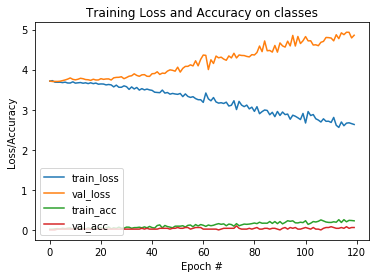

50/50 [==============================] - 0s 455us/step
Loss on test data: 4.9637719345092775
Accuracy on test data: 0.06
Correct / Total: 3/50


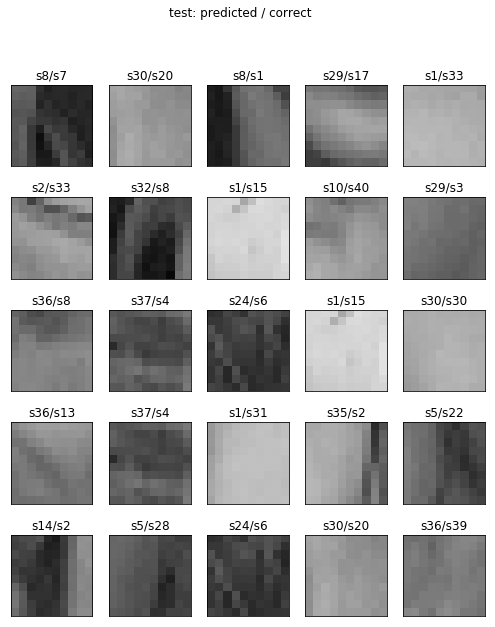

[INFO] building model 'crop_10x10_rand' ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 20, 10, 10)        1520      
_________________________________________________________________
activation_33 (Activation)   (None, 20, 10, 10)        0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 20, 5, 5)          0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 50, 5, 5)          25050     
_________________________________________________________________
activation_34 (Activation)   (None, 50, 5, 5)          0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 50, 2, 2)          0         
_________________________________________________________________
flatten_9 (Flatten)          (No

6/6 [==============================] - 0s 25ms/step - loss: 2.6551 - acc: 0.2182 - val_loss: 5.1520 - val_acc: 0.0800
Epoch 111/120
6/6 [==============================] - 0s 37ms/step - loss: 2.6977 - acc: 0.1875 - val_loss: 5.0601 - val_acc: 0.0600
Epoch 112/120
6/6 [==============================] - 0s 31ms/step - loss: 2.7178 - acc: 0.1759 - val_loss: 5.1334 - val_acc: 0.0600
Epoch 113/120
6/6 [==============================] - 0s 27ms/step - loss: 2.7912 - acc: 0.1208 - val_loss: 5.3272 - val_acc: 0.0400
Epoch 114/120
6/6 [==============================] - 0s 49ms/step - loss: 2.6802 - acc: 0.1979 - val_loss: 4.9622 - val_acc: 0.1000
Epoch 115/120
6/6 [==============================] - 0s 31ms/step - loss: 2.7648 - acc: 0.1875 - val_loss: 5.1493 - val_acc: 0.0600
Epoch 116/120
6/6 [==============================] - 0s 31ms/step - loss: 2.5438 - acc: 0.2712 - val_loss: 5.1790 - val_acc: 0.0600
Epoch 117/120
6/6 [==============================] - 0s 29ms/step - loss: 2.6256 - acc: 0.

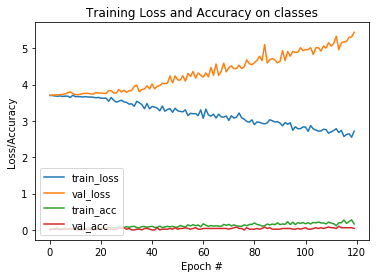

50/50 [==============================] - 0s 488us/step
Loss on test data: 5.70211784362793
Accuracy on test data: 0.06
Correct / Total: 3/50


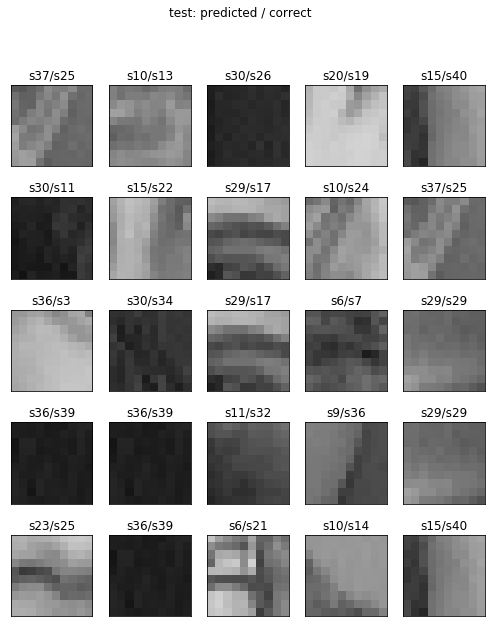

In [39]:
for kind in ['ul', 'll', 'ur', 'lr', 'rand', 'rand']:
    quickTest('crop_10x10_%s' % kind, cropData(data, 10, 10, kind=kind), 120)

# VGG-16

In [32]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

model = VGG16(weights='imagenet', include_top=False)

#img_path = 'elephant.jpg'
#img = image.load_img(img_path, target_size=(224, 224))
#x = image.img_to_array(img)
#x = np.expand_dims(x, axis=0)
#x = preprocess_input(x)

#features = model.predict(x)

def train_model_vgg(name, trainX, trainY, valX, valY, num_classes, img_size, epochs, batch_size=45, init_lr=1e-3, output=sys.stdout):
    aug = ImageDataGenerator(rotation_range=30, 
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode="nearest")
    
    # initialize the model
    print("[INFO] building model '%s' ..." % name, file=output)
#     model = LeNet.build(width=img_size[0],
#                         height=img_size[1],
#                         depth=3,
#                         classes=num_classes)
    model = VGG16(weights='imagenet', include_top=False)

    
    print(model.summary())
    
    loss = 'binary_crossentropy' if num_classes == 2 else 'categorical_crossentropy'
    
    print("[INFO] compiling model '%s' ..." % name, file=output)
    opt = Adam(lr=init_lr, decay=init_lr / epochs)
    #opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss=loss,
                  optimizer=opt,
                  metrics=["accuracy"])
    
    trainY_idx = np.arange(len(trainY[0]))

    # train the network
    steps_per_epoch = len(trainX) // batch_size
    print('Steps per epoch:', steps_per_epoch)
    print("[INFO] training network...", file=output)
    H = model.fit_generator(aug.flow(trainX, trainY),
                            validation_data=(valX, valY),
                            steps_per_epoch=steps_per_epoch,
                            epochs=epochs, verbose=1)

    # save the model to disk
    print("[INFO] serializing network...", file=output)
    save_path = 'models/%s.model' % name
    print("Saving model as ./%s" % save_path, file=output)
    model.save(save_path)
    
    return H, model

print('train_model_vgg')


train_model_weighted


/Users/npaul/anaconda/lib/python3.6/site-packages/keras/applications/vgg16.py:188: UserWarning: You are using the TensorFlow backend, yet you are using the Theano image data format convention (`image_data_format="channels_first"`). For best performance, set `image_data_format="channels_last"` in your Keras config at ~/.keras/keras.json.
  warnings.warn('You are using the TensorFlow backend, yet you '


In [36]:
print(data['image_size'])
history, model = train_model_vgg('vgg1',
                data['X_train'],
                data['y_train'],
                data['X_val'],
                data['y_val'],
                data['num_classes'],
                data['image_size'],
                2) #epochs

(92, 112)
[INFO] building model 'vgg1' ...


/Users/npaul/anaconda/lib/python3.6/site-packages/keras/applications/vgg16.py:188: UserWarning: You are using the TensorFlow backend, yet you are using the Theano image data format convention (`image_data_format="channels_first"`). For best performance, set `image_data_format="channels_last"` in your Keras config at ~/.keras/keras.json.
  warnings.warn('You are using the TensorFlow backend, yet you '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3, None, None)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, None, None)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, None, None)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, None, None)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, None, None)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, None, None)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, None, None)   0         
__________

ValueError: Error when checking target: expected block5_pool to have 4 dimensions, but got array with shape (50, 40)